In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [5]:
args = type('', (), {})()
args.version = ''
args.config = 'family_2'

In [6]:
import corner_templates

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

from corner_templates.io import get_pos, get_data, VectorFitting, interp_mask
from corner_templates.models import SpecialReLUNetwork, ReLUNetwork, AutoDecoderFamily, gradient
from corner_templates.utils import render_sdf, select_top2, gaussian_pyramid_loss, perm_inv_mse_channel_edge, fig2data, get_mgrid
exec('from corner_templates.configs.{} import *'.format(args.config))

torch.manual_seed(42)
device = 'cpu'

In [9]:
img_siren_global = AutoDecoderFamily(in_features=2, out_features=3, hidden_features=384, #Siren 4 # Relu 22 SpecialReLUNetwork
                  hidden_layers=6, outermost_linear=True, first_omega_0=1, hidden_omega_0=1, num_embed=2, num_glyphs=52)#+local_feature

img_siren_global.to(device)
save_dir = '../{}'
checkpoint = torch.load(save_dir.format('checkpoints/')+'checkpoint_generic.pt')
img_siren_global.load_state_dict(checkpoint['model_params'])


<All keys matched successfully>

# Interpolation

In [10]:
def interpolate_vectors(v1, v2, n):
    step = (v2 - v1) / (n - 1)
    vecs = []
    for i in range(n):
        vecs.append(v1 + i * step)
    return torch.stack(vecs, dim=0)

# Single glyph interpolation

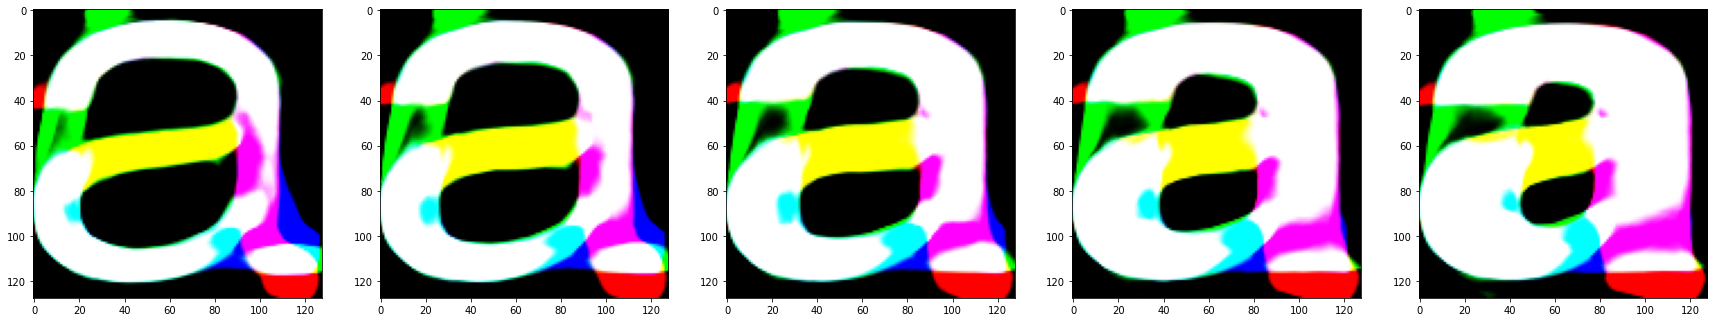

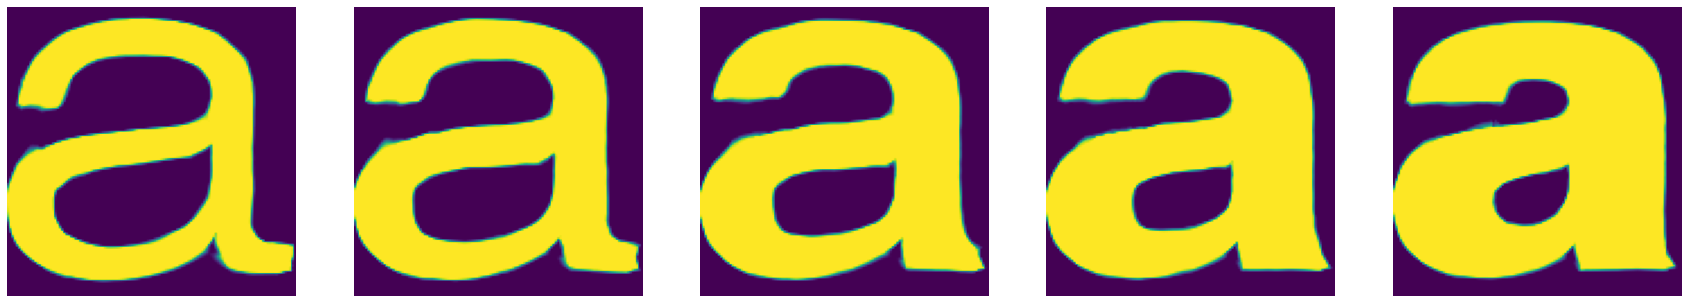

In [17]:
idx1 = 0
idx2 = 1
sidelength = 128
n = 5
one_hot = [0,]*52
one_hot[0] = 1

idx = torch.tensor([idx1, idx2], dtype=torch.long).to(device)
one_hot = torch.tensor(one_hot, dtype=torch.float32).to(device)

label_embed = img_siren_global.embed(idx)#
interp_embed = interpolate_vectors(label_embed[0], label_embed[1], n)

input = get_mgrid(sidelength, 2).reshape(-1, 2)
input = input[None,:,:].repeat(n, 1, 1).to(device)
input = input.clone().requires_grad_(True)
bs, wh, c = input.shape

label_embed = interp_embed[:, None, :].repeat([1,wh,1])
glyph_idx = one_hot[None, None, :].repeat([bs,wh,1])
x = torch.cat([input, glyph_idx, label_embed], dim=-1)
output = img_siren_global.network([input, x])

output_sig = F.sigmoid(output[0])*2 - 1    
output_render =  render_sdf(output_sig, 2/(sidelength))
final_render = torch.median(output_render, dim=-1)[0]

fig, axes = plt.subplots(1,n, figsize=(30,6))
for i in range(n):
    axes[i].imshow(output_render[i, :, :].cpu().view(img_size,img_size, 3).detach().numpy())
plt.show()

fig, axes = plt.subplots(1,n, figsize=(30,6))
for i in range(n):
    axes[i].imshow(final_render[i, :].cpu().view(img_size,img_size).detach().numpy())
    axes[i].axis('off')
plt.show()
plt.close()

# Whole family interpoation

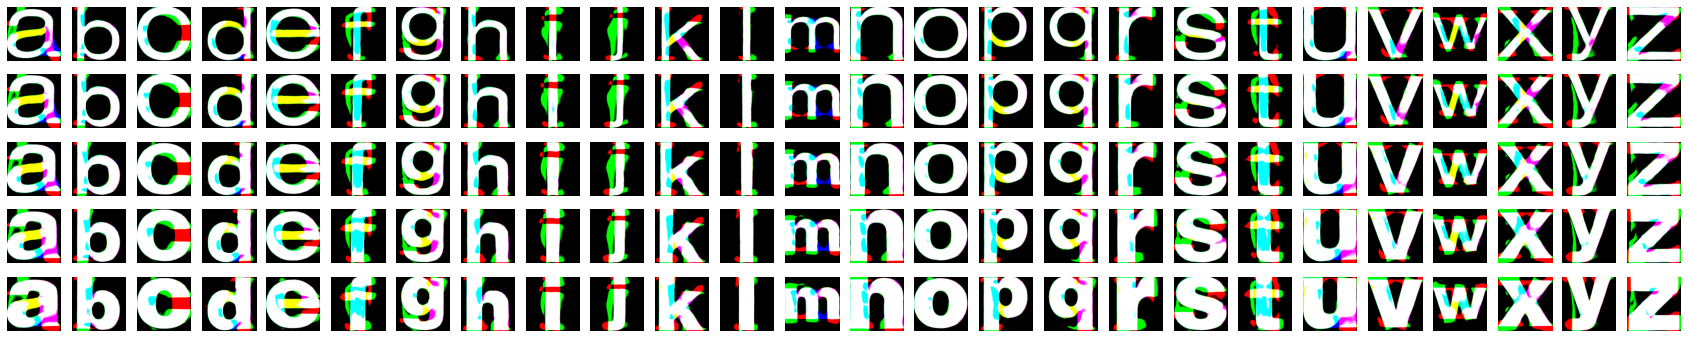

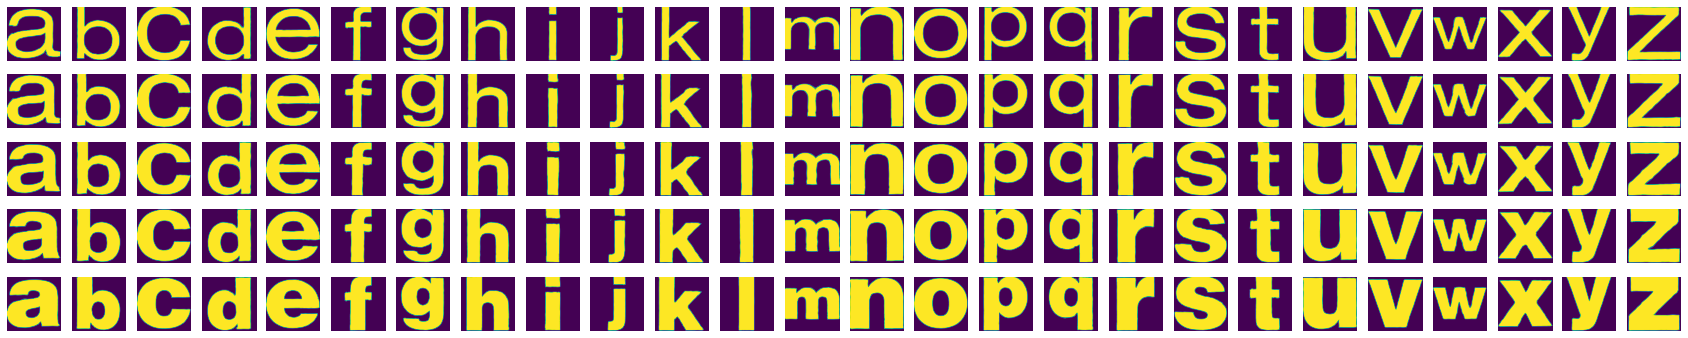

In [14]:
idx1 = 0
idx2 = 1
sidelength = 128
n = 5
fig1, axes1 = plt.subplots(n,26, figsize=(30,6))
fig2, axes2 = plt.subplots(n,26, figsize=(30,6))

for one_hot_idx in range(26):
    one_hot = [0,]*52
    one_hot[one_hot_idx] = 1

    idx = torch.tensor([idx1, idx2], dtype=torch.long).to(device)
    one_hot = torch.tensor(one_hot, dtype=torch.float32).to(device)

    label_embed = img_siren_global.embed(idx)#
    interp_embed = interpolate_vectors(label_embed[0], label_embed[1], n)

    input = get_mgrid(sidelength, 2).reshape(-1, 2)
    input = input[None,:,:].repeat(n, 1, 1).to(device)
    input = input.clone().requires_grad_(True)
    bs, wh, c = input.shape

    label_embed = interp_embed[:, None, :].repeat([1,wh,1])
    glyph_idx = one_hot[None, None, :].repeat([bs,wh,1])
    x = torch.cat([input, glyph_idx, label_embed], dim=-1)
    output = img_siren_global.network([input, x])

    output_sig = F.sigmoid(output[0])*2 - 1    
    output_render =  render_sdf(output_sig, 2/(sidelength))
    final_render = torch.median(output_render, dim=-1)[0]

    for i in range(n):
        axes1[i, one_hot_idx].imshow(output_render[i, :, :].cpu().view(img_size,img_size, 3).detach().numpy())
        axes1[i, one_hot_idx].axis('off')
#     plt.show()

    for i in range(n):
        axes2[i, one_hot_idx].imshow(final_render[i, :].cpu().view(img_size,img_size).detach().numpy())
        axes2[i, one_hot_idx].axis('off')
plt.show()
plt.close()

# Resampling

In [25]:
print(input.shape, one_hot.shape, label_embed.shape)

torch.Size([1, 16384, 2]) torch.Size([52]) torch.Size([1, 16384, 32])


In [27]:
idx1 = 0
sidelength = 128
resample_size = 1024
n = 1

one_hot = [0,]*52
one_hot[0] = 1
one_hot = torch.tensor(one_hot, dtype=torch.float32).to(device)

idx = torch.tensor([idx1, ], dtype=torch.long).to(device)
label_embed = img_siren_global.embed(idx)#
interp_embed = label_embed

input = get_mgrid(sidelength, 2).reshape(-1, 2)
input = input[None,:,:].repeat(n, 1, 1).to(device)
input = input.clone().requires_grad_(True)
bs, wh, c = input.shape
glyph_idx = one_hot[None, None, :].repeat([bs,wh,1])

label_embed = interp_embed[:, None, :].repeat([1,wh,1])
x = torch.cat([input, glyph_idx, label_embed], dim=-1)
output = img_siren_global.network([input, x])

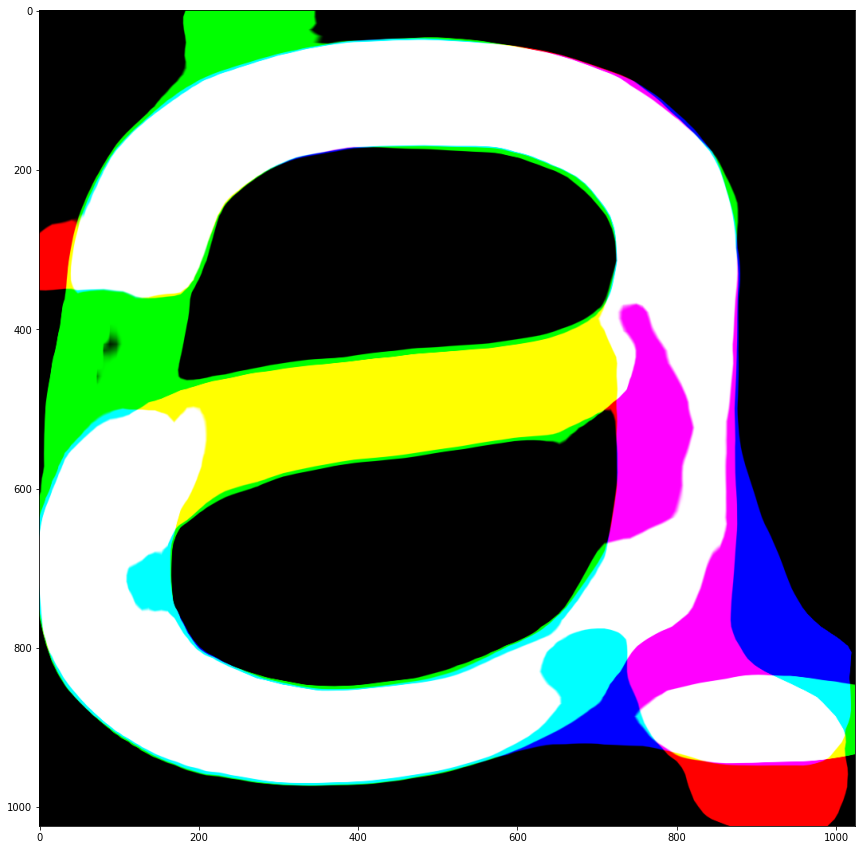

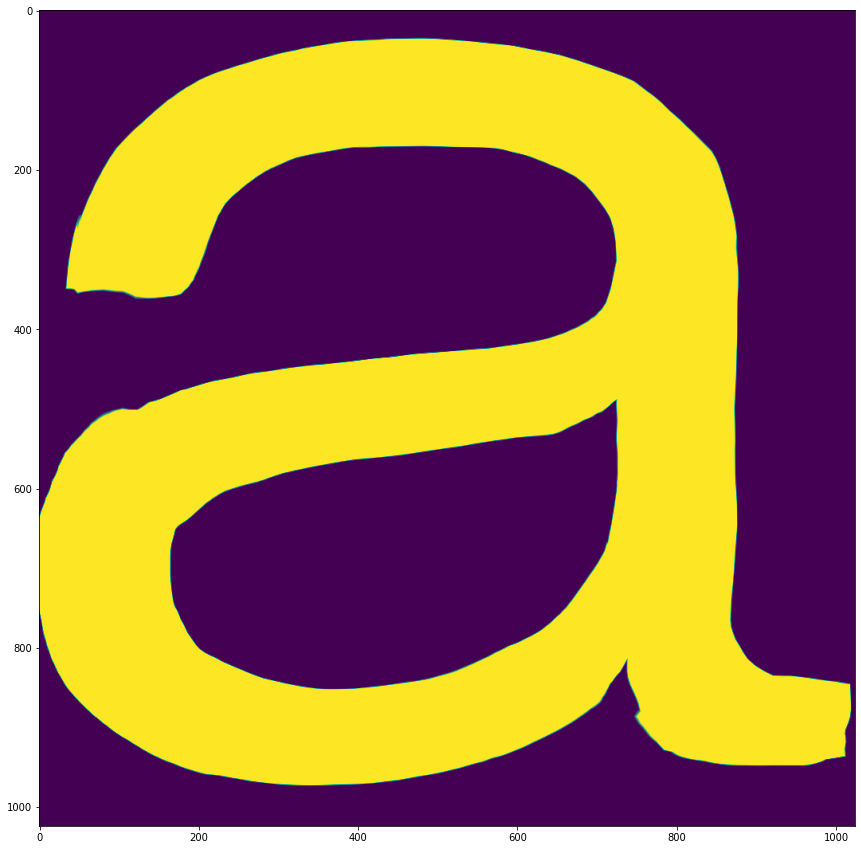

In [33]:
output_sig = F.sigmoid(output[0])*2 - 1
output_sig = output_sig.permute(0, 2, 1).view(1, 3, sidelength, sidelength)
output_sig = torch.nn.functional.upsample(output_sig, scale_factor=resample_size//sidelength, mode='bilinear', align_corners=True)
output_sig = output_sig.view(1, 3, -1).permute(0, 2, 1)

output_render =  render_sdf(output_sig, 2/(resample_size))
final_render = torch.median(output_render, dim=-1)[0]
# final_render =torch.mean(select_top2(output_render), dim=-1,
#                                       keepdims=True)
fig, axes = plt.subplots(1,1, figsize=(15,15))
axes.imshow(output_render[0, :, :].cpu().view(resample_size,resample_size, 3).detach().numpy())
plt.show()
fig, axes = plt.subplots(1,1, figsize=(15,15))
axes.imshow(final_render[0, :].cpu().view(resample_size,resample_size).detach().numpy())
plt.show()
plt.close()